**Import Statements**

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler  
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from keras import models
from keras import layers
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

**Reading Dataset from CSV file**

In [3]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


**DATA PREPROCESSING**

In [4]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [5]:
df.isnull().sum()
#no NaN values in dataset

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [6]:
df.dtypes
#dataset has catagorical data

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [7]:
#We need to convert all "object" datatypes to "float" or "int"
#column - Sex
#one-hot-encoding
df=pd.concat([df,pd.get_dummies(df["Sex"],prefix="Gender")],axis=1)
df.drop(["Sex"],axis=1,inplace=True)
df.head()

,Age,BP,Cholesterol,Na_to_K,Drug,Gender_F,Gender_M
0,23,HIGH,HIGH,25.355,DrugY,1,0
1,47,LOW,HIGH,13.093,drugC,0,1
2,47,LOW,HIGH,10.114,drugC,0,1
3,28,NORMAL,HIGH,7.798,drugX,1,0
4,61,LOW,HIGH,18.043,DrugY,1,0


In [8]:
#similarly we get rid of all categorical data except "Drug" which is output column
df=pd.concat([df,pd.get_dummies(df["BP"],prefix="BP")],axis=1)
df.drop(["BP"],axis=1,inplace=True)
df=pd.concat([df,pd.get_dummies(df["Cholesterol"],prefix="Cholesterol")],axis=1)
df.drop(["Cholesterol"],axis=1,inplace=True)
drug_type = df["Drug"]
df.drop(["Drug"],axis=1,inplace=True)
df=pd.concat([df,drug_type], axis=1)

In [9]:
df.head()

,Age,Na_to_K,Gender_F,Gender_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug
0,23,25.355,1,0,1,0,0,1,0,DrugY
1,47,13.093,0,1,0,1,0,1,0,drugC
2,47,10.114,0,1,0,1,0,1,0,drugC
3,28,7.798,1,0,0,0,1,1,0,drugX
4,61,18.043,1,0,0,1,0,1,0,DrugY


In [10]:
#now we scale the numerical columns of dataset ['Age', 'Na_to_K']
df["Age"]=(df["Age"]-df["Age"].mean())/(df["Age"].max()-df["Age"].min())
df["Na_to_K"]=(df["Na_to_K"]-df["Na_to_K"].mean())/(df["Na_to_K"].max()-df["Na_to_K"].min())

In [11]:
#now our dataset is ready (preprocessed)
df.head()

,Age,Na_to_K,Gender_F,Gender_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug
0,-0.361271,0.289903,1,0,1,0,0,1,0,DrugY
1,0.045508,-0.093548,0,1,0,1,0,1,0,drugC
2,0.045508,-0.186706,0,1,0,1,0,1,0,drugC
3,-0.276525,-0.259131,1,0,0,0,1,1,0,drugX
4,0.282797,0.061246,1,0,0,1,0,1,0,DrugY


**Split Data into X, Y**

In [12]:
X = df.iloc[:,0:-1]
Y = df.iloc[:,[-1]]

In [13]:
X.head()

,Age,Na_to_K,Gender_F,Gender_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,-0.361271,0.289903,1,0,1,0,0,1,0
1,0.045508,-0.093548,0,1,0,1,0,1,0
2,0.045508,-0.186706,0,1,0,1,0,1,0
3,-0.276525,-0.259131,1,0,0,0,1,1,0
4,0.282797,0.061246,1,0,0,1,0,1,0


In [14]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


In [15]:
X = X.astype(float)

In [ ]:
encoder = OneHotEncoder()

encoded_Y = encoder.fit(Y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(Y.values.reshape(-1,1)).toarray()

encoded_Y

In [17]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(X, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

**Build ANN model**

In [18]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'Bird_ANN_2FC_F64_64_epoch_25'

In [19]:
input_shape = trainX.shape[1]

n_batch_size = 10

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 25

num_classes = trainY.shape[1]

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: 9
Batch Size: 10

Steps per Epoch: 13

Validation Steps: 3
Test Steps: 3

Number of Epochs: 25

Number of Classes: 5


In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [27]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

**ANN MODEL TRAINING**

In [29]:
history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0527 - accuracy: 1.0000

13/13 [==============================] - 1s 109ms/step - loss: 0.1529 - accuracy: 0.9462 - val_loss: 0.2459 - val_accuracy: 0.9333
Epoch 2/25
 1/13 [=>............................] - ETA: 0s - loss: 0.1364 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.1488 - accuracy: 0.9767 - val_loss: 0.2215 - val_accuracy: 0.9000
Epoch 3/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0482 - accuracy: 1.0000

13/13 [==============================] - 1s 51ms/step - loss: 0.0907 - accuracy: 0.9922 - val_loss: 0.2121 - val_accuracy: 0.9667
Epoch 4/25
13/13 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.9612 - val_loss: 0.2169 - val_accuracy: 0.8667
Epoch 5/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000

13/13 [==============================] - 1s 52ms/step - loss: 0.1004 - accuracy: 0.9690 - val_loss: 0.2083 - val_accuracy: 0.9333
Epoch 6/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0455 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.0977 - accuracy: 0.9845 - val_loss: 0.1926 - val_accuracy: 0.9333
Epoch 7/25
 1/13 [=>............................] - ETA: 0s - loss: 0.1076 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.0823 - accuracy: 0.9767 - val_loss: 0.1760 - val_accuracy: 0.9333
Epoch 8/25
13/13 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9845 - val_loss: 0.1996 - val_accuracy: 0.9000
Epoch 9/25
 1/13 [=>............................] - ETA: 0s - loss: 0.1438 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.0761 - accuracy: 0.9922 - val_loss: 0.1718 - val_accuracy: 0.9333
Epoch 10/25
13/13 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.9767 - val_loss: 0.2001 - val_accuracy: 0.9000
Epoch 11/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0500 - accuracy: 1.0000

13/13 [==============================] - 1s 51ms/step - loss: 0.0734 - accuracy: 0.9922 - val_loss: 0.1661 - val_accuracy: 0.9667
Epoch 12/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0443 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.0749 - accuracy: 0.9767 - val_loss: 0.1609 - val_accuracy: 0.9333
Epoch 13/25
13/13 [==============================] - 0s 3ms/step - loss: 0.0599 - accuracy: 0.9922 - val_loss: 0.1787 - val_accuracy: 0.9000
Epoch 14/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0544 - accuracy: 1.0000

13/13 [==============================] - 1s 70ms/step - loss: 0.0637 - accuracy: 0.9922 - val_loss: 0.1579 - val_accuracy: 0.9667
Epoch 15/25
13/13 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.1731 - val_accuracy: 0.9333
Epoch 16/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0192 - accuracy: 1.0000

13/13 [==============================] - 1s 50ms/step - loss: 0.0553 - accuracy: 0.9767 - val_loss: 0.1574 - val_accuracy: 0.9667
Epoch 17/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0769 - accuracy: 1.0000

13/13 [==============================] - 1s 51ms/step - loss: 0.0582 - accuracy: 0.9922 - val_loss: 0.1450 - val_accuracy: 0.9333
Epoch 18/25
 1/13 [=>............................] - ETA: 0s - loss: 0.0483 - accuracy: 1.0000

13/13 [==============================] - 1s 63ms/step - loss: 0.0471 - accuracy: 0.9922 - val_loss: 0.1334 - val_accuracy: 0.9667
Epoch 19/25
13/13 [==============================] - 0s 4ms/step - loss: 0.0520 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9667
Epoch 20/25
13/13 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.9922 - val_loss: 0.1625 - val_accuracy: 0.9333
Epoch 21/25
13/13 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 1.0000 - val_loss: 0.1629 - val_accuracy: 0.9333
Epoch 22/25
13/13 [==============================] - 0s 4ms/step - loss: 0.0426 - accuracy: 1.0000 - val_loss: 0.1411 - val_accuracy: 0.9333
Epoch 23/25
13/13 [==============================] - 0s 4ms/step - loss: 0.0453 - accuracy: 0.9922 - val_loss: 0.1511 - val_accuracy: 0.9333
Epoch 24/25
13/13 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9333
Epoch 25/25
13/13 [=====

In [30]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.152878,0.946154,0.245887,0.933333
1,2,0.148836,0.976744,0.221497,0.900000
2,3,0.090677,0.992248,0.212096,0.966667
3,4,0.126639,0.961240,0.216929,0.866667
4,5,0.100425,0.968992,0.208302,0.933333


In [31]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
17,18,0.047104,0.992248,0.133415,0.966667


In [33]:
class_assignment = dict(zip(Y, encoded_Y))

df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_temp = df_temp.stack()
df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']

df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:')
class_assignment

Class assignment:


{'Drug': array([1., 0., 0., 0., 0.])}

In [35]:
import pickle as pk
pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))


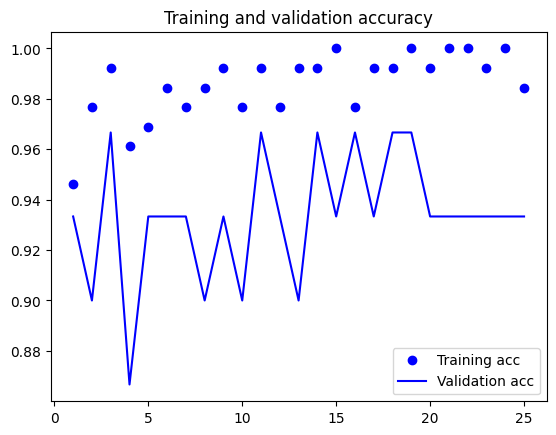

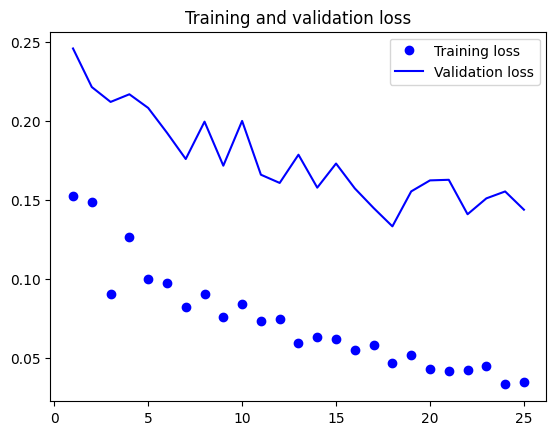

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
from keras.models import load_model
import shutil
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [42]:
best_model = load_model(model_name_temp)

In [43]:
test_loss, test_acc = best_model.evaluate(testX,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

3/3 [==============================] - 0s 4ms/step - loss: 0.2180 - accuracy: 0.9355

Test Accuracy: 0.9354838728904724


**PREDICTION OF TEST DATASET**

In [44]:
y_pred = model.predict(testX)
y_pred[:5]

1/1 [==============================] - 0s 102ms/step


array([[3.2483455e-04, 6.4122176e-04, 5.0399526e-06, 9.5679675e-04,
        9.9807209e-01],
       [6.2810071e-04, 3.2386768e-05, 1.7518594e-04, 1.2941280e-03,
        9.9787021e-01],
       [9.9999875e-01, 9.8449071e-10, 1.1758245e-06, 6.6540573e-10,
        1.3241096e-10],
       [4.8953784e-01, 6.2867268e-03, 5.0391203e-01, 9.3817900e-05,
        1.6966887e-04],
       [9.1120887e-01, 8.4398103e-05, 2.9949857e-07, 9.5419942e-05,
        8.8611193e-02]], dtype=float32)

In [46]:
encoder_reload = pk.load(open(checkpoint_dir + '/' + 'encoder.pkl','rb'))

In [47]:
re_transformed_y_pred = encoder_reload.inverse_transform(y_pred)
re_transformed_y_pred[:5]

array([['drugX'],
       ['drugX'],
       ['DrugY'],
       ['drugB'],
       ['DrugY']], dtype=object)

In [48]:
testX['re_transformed_y_pred'] = re_transformed_y_pred
testX

,Age,Na_to_K,Gender_F,Gender_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,re_transformed_y_pred
182,-0.412119,-0.137547,1.0,0.0,0.0,1.0,0.0,0.0,1.0,drugX
16,0.418390,-0.144771,0.0,1.0,0.0,1.0,0.0,0.0,1.0,drugX
97,0.198051,0.291154,1.0,0.0,1.0,0.0,0.0,1.0,0.0,DrugY
41,0.231949,-0.057711,1.0,0.0,1.0,0.0,0.0,0.0,1.0,drugB
71,-0.276525,0.112281,1.0,0.0,0.0,0.0,1.0,1.0,0.0,DrugY
7,-0.056186,-0.157842,0.0,1.0,0.0,1.0,0.0,1.0,0.0,drugC
32,0.079407,-0.158562,0.0,1.0,0.0,1.0,0.0,0.0,1.0,drugX
133,-0.344322,0.303381,0.0,1.0,0.0,0.0,1.0,1.0,0.0,DrugY
4,0.282797,0.061246,1.0,0.0,0.0,1.0,0.0,1.0,0.0,DrugY
137,-0.157881,-0.099771,1.0,0.0,1.0,0.0,0.0,1.0,0.0,drugA
